In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import pathlib
import json
sns.set(font_scale=1.5, style='whitegrid')
pd.set_option('display.max.columns', 999)

output_dir = pathlib.Path("./report/")
output_dir.mkdir(parents=True, exist_ok=True)

# Evaluacion de estado de experimentos

In [216]:
is_path = "./data/is_experiments"
p = pathlib.Path(is_path)
ignore = ["test.csv"]
all_results = pd.DataFrame()
files = []
for i in p.glob('**/*.csv'):
    if not i.name  in (ignore):
        partial = pd.read_csv(i.absolute())
        partial['file'] = i.name
        all_results = pd.concat([all_results, partial], ignore_index = True)
        files.append(i.name)
all_results['Total Time'] = all_results.timeLSH + all_results.timeIS
all_results['total'] = all_results.tp + all_results.tn + all_results.fn + all_results.fp
all_results['samples by bucket average (relative)'] = all_results.buckAvg/all_results.total*100.0

all_results['model_complexity'] =  all_results.trees*all_results.depth

In [202]:
all_results.sort_values(by = 'samples by bucket average (relative)')

,instanceSelection,lshMEthod,sizeBucket,ands,ors,imbalance,neigh,subBuckets,distance,isMethod,trees,depth,type,k,tp,tn,fp,fn,sensibility,specificity,precision,accuracy,F1,Gmean,wtdAcc,AreaROC,timeLSH,timeIS,buckets,buckMax,buckMin,buckAvg,reduction,file,Total Time,total,samples by bucket average (relative)
18060,IS,projection,0.1,10,1,False,4,1000,6,entropy,25,10,Train,1,856.0,3626022.0,856.0,2145.0,28.523825,99.976398,50.0,99.917325,36.325058,53.401398,49.959597,0.995649,3.028876,1.903563,3627396.0,2361.0,1.0,1.108987,0.902130,p2pAllResults.csv,4.932439,3629879.0,0.000031
18832,IS,projection,0.1,10,1,False,4,1000,6,entropy,25,20,Train,4,2330.0,3623303.0,2330.0,749.0,75.673920,99.935735,50.0,99.915149,60.214498,86.962802,82.952465,0.998612,4.612612,3.652206,3624488.0,2519.0,1.0,1.109231,0.901998,p2pAllResults.csv,8.264819,3628712.0,0.000031
19126,IS,hyperplanes-projection,0.1,10,1,False,4,1000,6,entropy,50,20,Train,5,2294.0,3616221.0,2294.0,726.0,75.960265,99.936604,50.0,99.916610,60.304942,87.127555,83.153167,0.999247,6.756153,2.460565,3618414.0,1877.0,1.0,1.111559,0.899843,p2pAllResults.csv,9.216718,3621535.0,0.000031
18858,IS,hyperplanes-projection,0.1,10,1,False,4,1000,6,entropy,50,30,Train,4,2987.0,3614397.0,2987.0,63.0,97.934426,99.917427,50.0,99.915756,66.201241,98.920958,98.529326,0.999323,4.634958,3.808909,3616126.0,3608.0,1.0,1.111796,0.899775,p2pAllResults.csv,8.443867,3620434.0,0.000031
18584,IS,hyperplanes-projection,0.1,10,1,False,4,1000,6,entropy,50,10,Train,3,819.0,3613441.0,819.0,2237.0,26.799738,99.977340,50.0,99.915517,34.895611,51.762598,48.753019,0.995453,5.527002,2.626307,3614354.0,2267.0,1.0,1.112765,0.899197,p2pAllResults.csv,8.153309,3617316.0,0.000031
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15808,IS,hyperplanes,0.1,2,1,False,4,1000,6,drop3,10,10,Train,3,86.0,147.0,86.0,0.0,100.000000,63.090129,50.0,73.040752,66.666667,79.429295,88.927039,1.000000,0.066728,23.878071,4.0,90632.0,24257.0,56942.250000,0.001023,fraudkAllResults.csv,23.944799,319.0,17850.235110
15810,IS,hyperplanes,0.1,2,1,False,4,1000,6,drop3,10,20,Train,3,84.0,146.0,84.0,0.0,100.000000,63.478261,50.0,73.248408,66.666667,79.673246,89.043478,1.000000,0.080130,23.579809,4.0,94218.0,22145.0,56942.250000,0.001010,fraudkAllResults.csv,23.659939,314.0,18134.474522
16676,IS,hyperplanes,0.1,2,1,False,4,1000,6,drop3,10,30,Train,5,81.0,150.0,81.0,0.0,100.000000,64.935065,50.0,74.038462,66.666667,80.582296,89.480519,0.993902,0.074331,22.516251,4.0,86162.0,29798.0,56931.250000,0.001019,fraudkAllResults.csv,22.590582,312.0,18247.195513
16674,IS,hyperplanes,0.1,2,1,False,4,1000,6,drop3,10,20,Train,5,85.0,137.0,85.0,0.0,100.000000,61.711712,50.0,72.312704,66.666667,78.556802,88.513514,0.994186,0.064694,24.212395,4.0,94153.0,18291.0,56931.250000,0.000979,fraudkAllResults.csv,24.277089,307.0,18544.381107


In [3]:
assert (all_results.groupby('file')['lshMEthod'].apply(lambda x: pd.isnull(x).sum()).sum(), 0)

In [4]:
def checks_params(df, filen, isMethod, lshMEthod,imbalance, ifis='IS'):
    check = df[(df.file == filen) & \
    (df.instanceSelection==ifis) & (df.isMethod == isMethod) & \
    (df.lshMEthod==lshMEthod) & (df.imbalance==imbalance)].groupby(['k', 'trees', 'depth', "ands", "ors"])['timeLSH'].count()

    assert(check[check.values!=2].sum(), 0)
    return(check)

checks = checks_params(all_results, "fraudkAllResults.csv", "entropy", "hyperplanes", False)
complete_aux_params = checks.reset_index()[['k', 'trees', 'depth', "ands", "ors"]].drop_duplicates()
complete_aux_params.to_csv(output_dir / "complete_aux_params.csv", index = False)

In [5]:
def checks_params_complete(df, filen, isMethod, lshMEthod,imbalance, ifis='IS'):

    auxs_params = ['k', 'trees', 'depth', "ands", "ors"]
    complete_aux_params= pd.read_csv(output_dir / "complete_aux_params.csv")
    complete_aux_params['aux'] = 1
    check = df[(df.file == filen) & \
    (df.instanceSelection==ifis) & (df.isMethod == isMethod) & \
    (df.lshMEthod==lshMEthod) & (df.imbalance==imbalance)].groupby(auxs_params)['timeLSH'].count()
    if(check.shape[0]==0):
        m = f"** missing ALL experiments for file {filen}, {isMethod}, {lshMEthod}, imabalance = {imbalance}"
        #print(m)
        return(m,None)
    else:
        assert(check[check.values!=2].sum(), 0)
        check = pd.merge(check, complete_aux_params, how = 'right', on = auxs_params)
        if (check.timeLSH.isnull().sum()>0):
            m= f"**** missing AUX params for file {filen}, {isMethod}, {lshMEthod}, imabalance = {imbalance}"
            add_m = json.dumps(check[check.timeLSH.isnull()][auxs_params].to_dict(orient = "records"), indent=1, sort_keys=True)
            #print(m)
            #print (add_m)
            #print("****")
            return(m, add_m)
        else:
            m = f"*All OK!!!!! for {filen}, {isMethod},{lshMEthod}, {imbalance}"
            #print(m)
            return(m,None)

In [10]:
lshMEthods = ['hyperplanes', 'hyperplanes-projection', 'projection']
isMEthod = ['entropy','drop3']
combinations = [(x,y,z) for x in lshMEthods for y in files for z in isMEthod]

check_result = pd.DataFrame()
ii = 0 
for lsh, file_n, isM in combinations:
    meesage,add = checks_params_complete(all_results, file_n, isM, lsh, imbalance = False)
    partial = pd.DataFrame(data = {'lshMEthod': lsh, 'isMethod': isM, 
        'fileName': file_n, 'check_message':meesage, 'add_msj': add}, index = [ii]) 
    check_result = pd.concat([check_result,partial], ignore_index = True)
    ii+=1
check_result.sort_values(by = ['fileName', 'isMethod', 'lshMEthod'])

,lshMEthod,isMethod,fileName,check_message,add_msj
5,hyperplanes,drop3,fraudkAllResults.csv,"*All OK!!!!! for fraudkAllResults.csv, drop3,h...",None
13,hyperplanes-projection,drop3,fraudkAllResults.csv,**** missing AUX params for file fraudkAllResu...,"[\n {\n ""ands"": 8,\n ""depth"": 10,\n ""k"": 1,..."
21,projection,drop3,fraudkAllResults.csv,**** missing AUX params for file fraudkAllResu...,"[\n {\n ""ands"": 8,\n ""depth"": 10,\n ""k"": 1,..."
4,hyperplanes,entropy,fraudkAllResults.csv,"*All OK!!!!! for fraudkAllResults.csv, entropy...",None
12,hyperplanes-projection,entropy,fraudkAllResults.csv,"*All OK!!!!! for fraudkAllResults.csv, entropy...",None
20,projection,entropy,fraudkAllResults.csv,"*All OK!!!!! for fraudkAllResults.csv, entropy...",None
7,hyperplanes,drop3,p2pAllResults.csv,** missing ALL experiments for file p2pAllResu...,None
15,hyperplanes-projection,drop3,p2pAllResults.csv,** missing ALL experiments for file p2pAllResu...,None
23,projection,drop3,p2pAllResults.csv,** missing ALL experiments for file p2pAllResu...,None
6,hyperplanes,entropy,p2pAllResults.csv,**** missing AUX params for file p2pAllResults...,"[\n {\n ""ands"": 10,\n ""depth"": 20,\n ""k"": 2..."


In [12]:
lshMEthods = ['hyperplanes', 'hyperplanes-projection', 'projection']
isMEthod = ['entropy','drop3']
combinations = [(x,y,z) for x in lshMEthods for y in files for z in isMEthod if y!='susyAllResults.csv']

check_result = pd.DataFrame()
ii = 0 
for lsh, file_n, isM in combinations:
    meesage,add = checks_params_complete(all_results, file_n, isM, lsh, imbalance = True)
    partial = pd.DataFrame(data = {'lshMEthod': lsh, 'isMethod': isM, 
        'fileName': file_n, 'check_message':meesage, 'add_msj': add}, index = [ii]) 
    check_result = pd.concat([check_result,partial], ignore_index = True)
    ii+=1
check_result.sort_values(by = ['fileName', 'isMethod', 'lshMEthod'])

,lshMEthod,isMethod,fileName,check_message,add_msj
3,hyperplanes,drop3,fraudkAllResults.csv,"*All OK!!!!! for fraudkAllResults.csv, drop3,h...",None
9,hyperplanes-projection,drop3,fraudkAllResults.csv,"*All OK!!!!! for fraudkAllResults.csv, drop3,h...",None
15,projection,drop3,fraudkAllResults.csv,"*All OK!!!!! for fraudkAllResults.csv, drop3,p...",None
2,hyperplanes,entropy,fraudkAllResults.csv,"*All OK!!!!! for fraudkAllResults.csv, entropy...",None
8,hyperplanes-projection,entropy,fraudkAllResults.csv,"*All OK!!!!! for fraudkAllResults.csv, entropy...",None
14,projection,entropy,fraudkAllResults.csv,"*All OK!!!!! for fraudkAllResults.csv, entropy...",None
5,hyperplanes,drop3,p2pAllResults.csv,** missing ALL experiments for file p2pAllResu...,None
11,hyperplanes-projection,drop3,p2pAllResults.csv,** missing ALL experiments for file p2pAllResu...,None
17,projection,drop3,p2pAllResults.csv,** missing ALL experiments for file p2pAllResu...,None
4,hyperplanes,entropy,p2pAllResults.csv,** missing ALL experiments for file p2pAllResu...,None


## Comparacion entre metodos desde el punto de vista  del numero de cubetas

In [175]:
def plotBuckets(df, col = 'imbalance', y = 'buckets',  x = 'ands', logy = True, logx=False):
    fil = (df.instanceSelection == 'IS') & (df.type == 'Train')

    df_pb_to_plot = df[fil].copy()
    
    plot = sns.relplot(x=x, y=y, col = col, height = 6, aspect=2,
                   data=df_pb_to_plot, kind="line",ci=10,
                   palette='gist_gray', style = 'lshMEthod', linewidth=3.5, 
                       hue = 'lshMEthod')
    if logy:
        plot.set(yscale="log")
    if logx:
        plot.set(xscale="log")

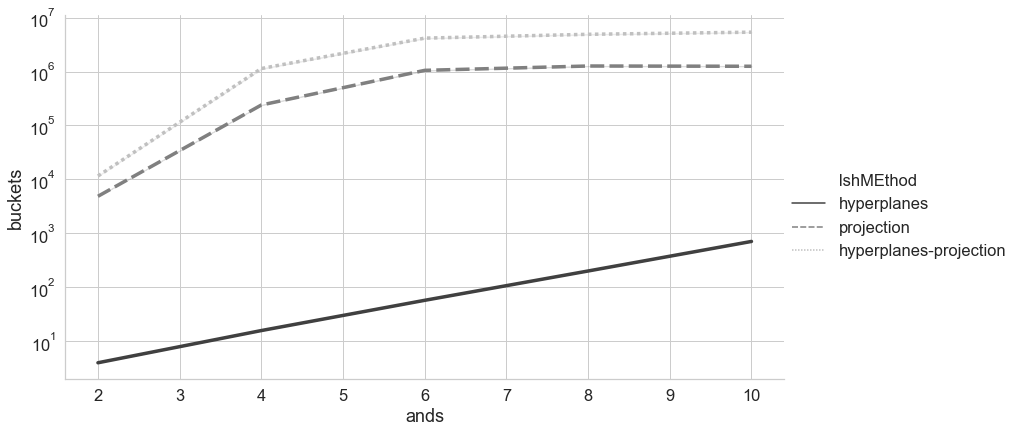

In [176]:
plotBuckets(all_results[all_results.imbalance==False], None)

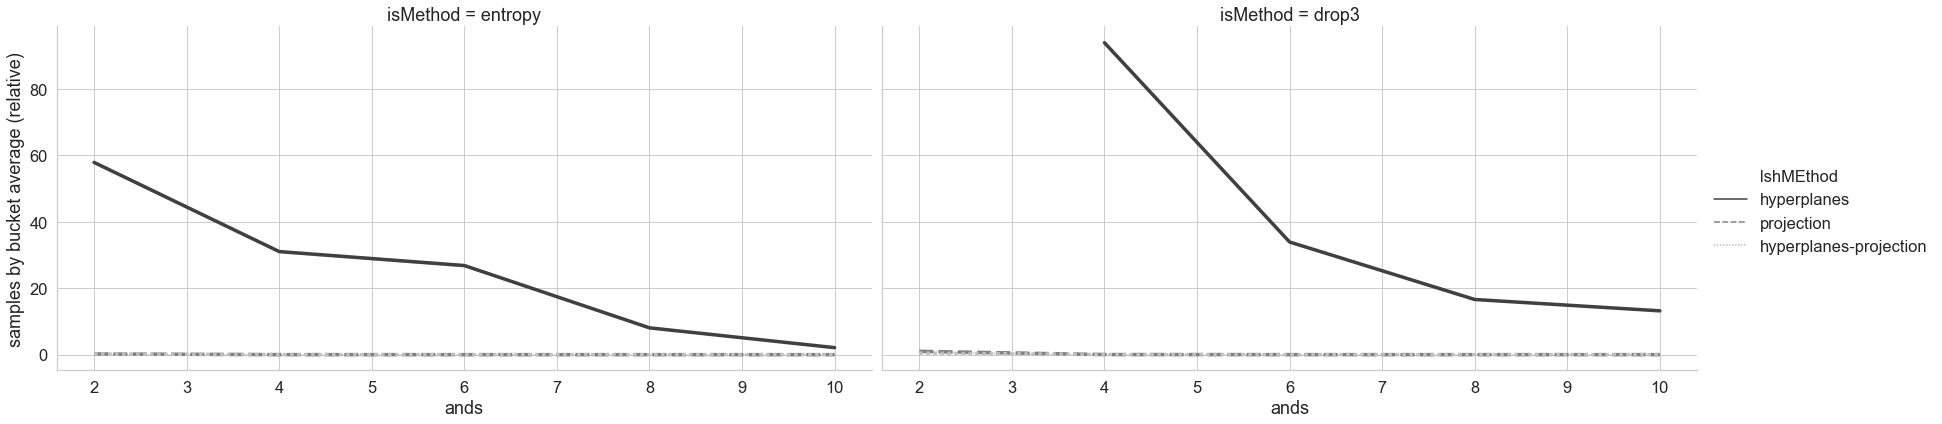

In [204]:
plotBuckets(all_results[(all_results.imbalance==False) & 
(all_results['samples by bucket average (relative)'] <= 100)],
col = 'isMethod', 
y='samples by bucket average (relative)', x = 'ands',  logy = False, logx= False)

usando el metodo de hiperplanos, el aumento de los buckets es mas estable en relacion con el el numero de ands. el metodo de la distribuciones p-estables crear mucho mas buckets por numero ands. Al combinar los dos metodos, se logran la creacion de aun mas buckets por cada ands. Para los metodos de la distribucion p-estable y la cambinacion de hiperplanos y p-estables, se observa que despues 6 ands el numero de buckets tiende a estabilizarse.

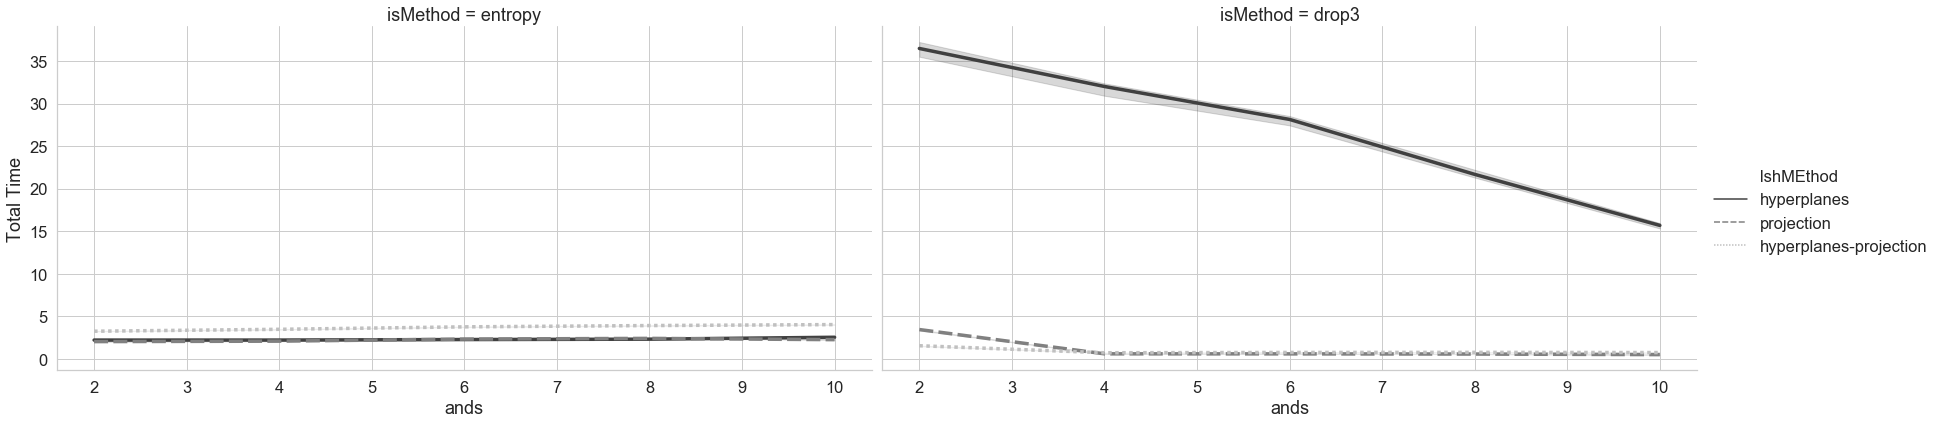

In [178]:
plotBuckets(all_results[all_results.imbalance==False], col = 'isMethod', y='Total Time', logy = False)

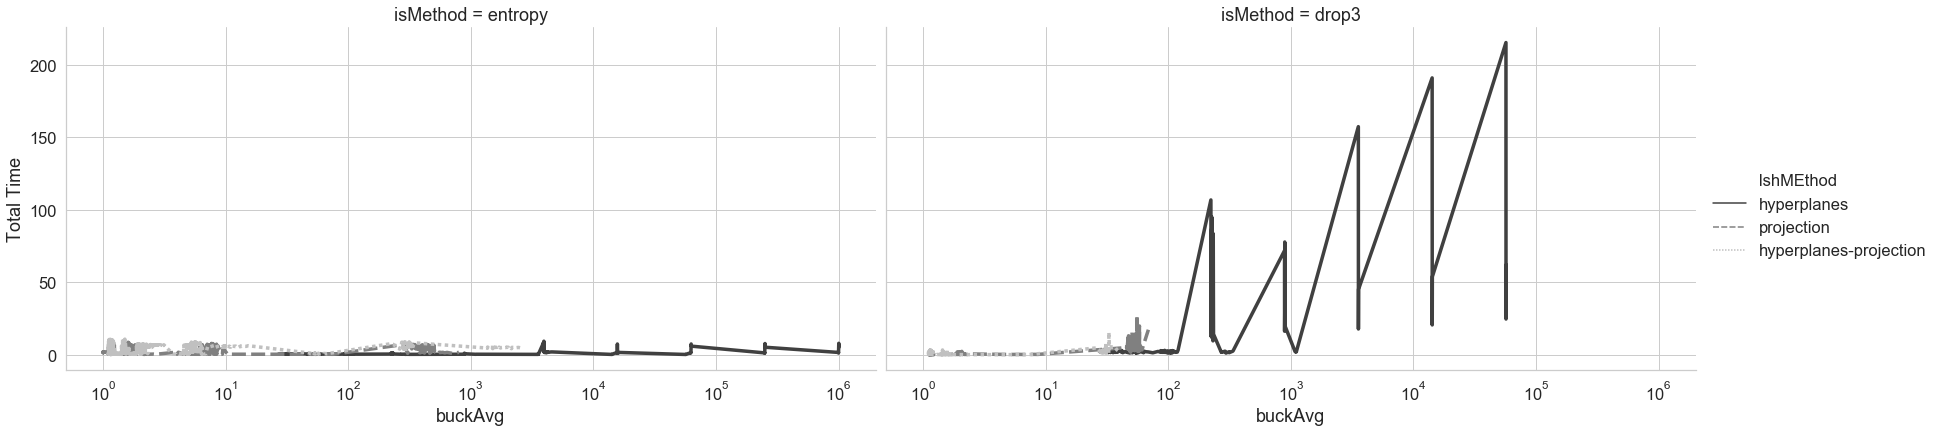

In [179]:
plotBuckets(all_results[all_results.imbalance==False], col = 'isMethod', y='Total Time', x = 'buckAvg',  logy = False, logx= True)

Al comprar como impacta el numero de ands y por consecuente el numero de buckets que algoritmo debe procesar a la hora de realizar la seleccion de instancias, se observa que sin importar el metodo de LSH, el metodo de seleccion de instancias por medio de la entropia tiene un tiempo de procesamiento que no es influenciado fuertemete por el metodo de LSH. En drop3, el tiempo de procesamiento depende del numero de ands, pero se comienza a estabilizar despues de 4 ands, lo que coincide que el drop3 es totalmente influenciado por el numero de muestras

## Comparacion entre metodos desde el punto de vista  de la reducciòn

In [79]:
def plotReduction(df, col = 'isMethod', row = None):
    fil = (df['instanceSelection'] == 'IS') & (df['type'] == 'Train')

    df_pb_to_plot = df[fil].copy()
    
    df_pb_to_plot['Reduction of DataSet(%)'] = (1 - df_pb_to_plot['reduction'])*100.0

    plot = sns.relplot(x="ands", y="Reduction of DataSet(%)", height = 6, aspect=2, data=df_pb_to_plot, 
                       kind="line",ci=10,palette='gist_gray', style = 'lshMEthod', 
                       linewidth=3.5, hue = 'lshMEthod', col = col, row=row)

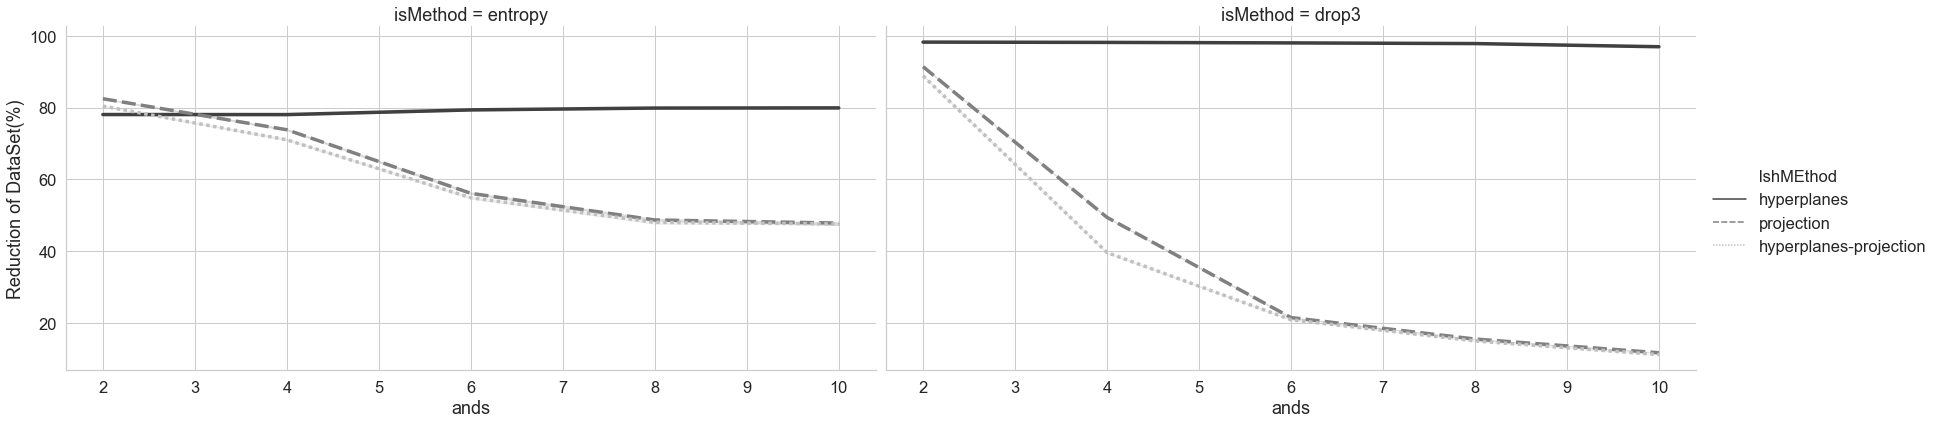

In [80]:
plotReduction(all_results[all_results.imbalance==False])

Drop3 reduce the dataset with

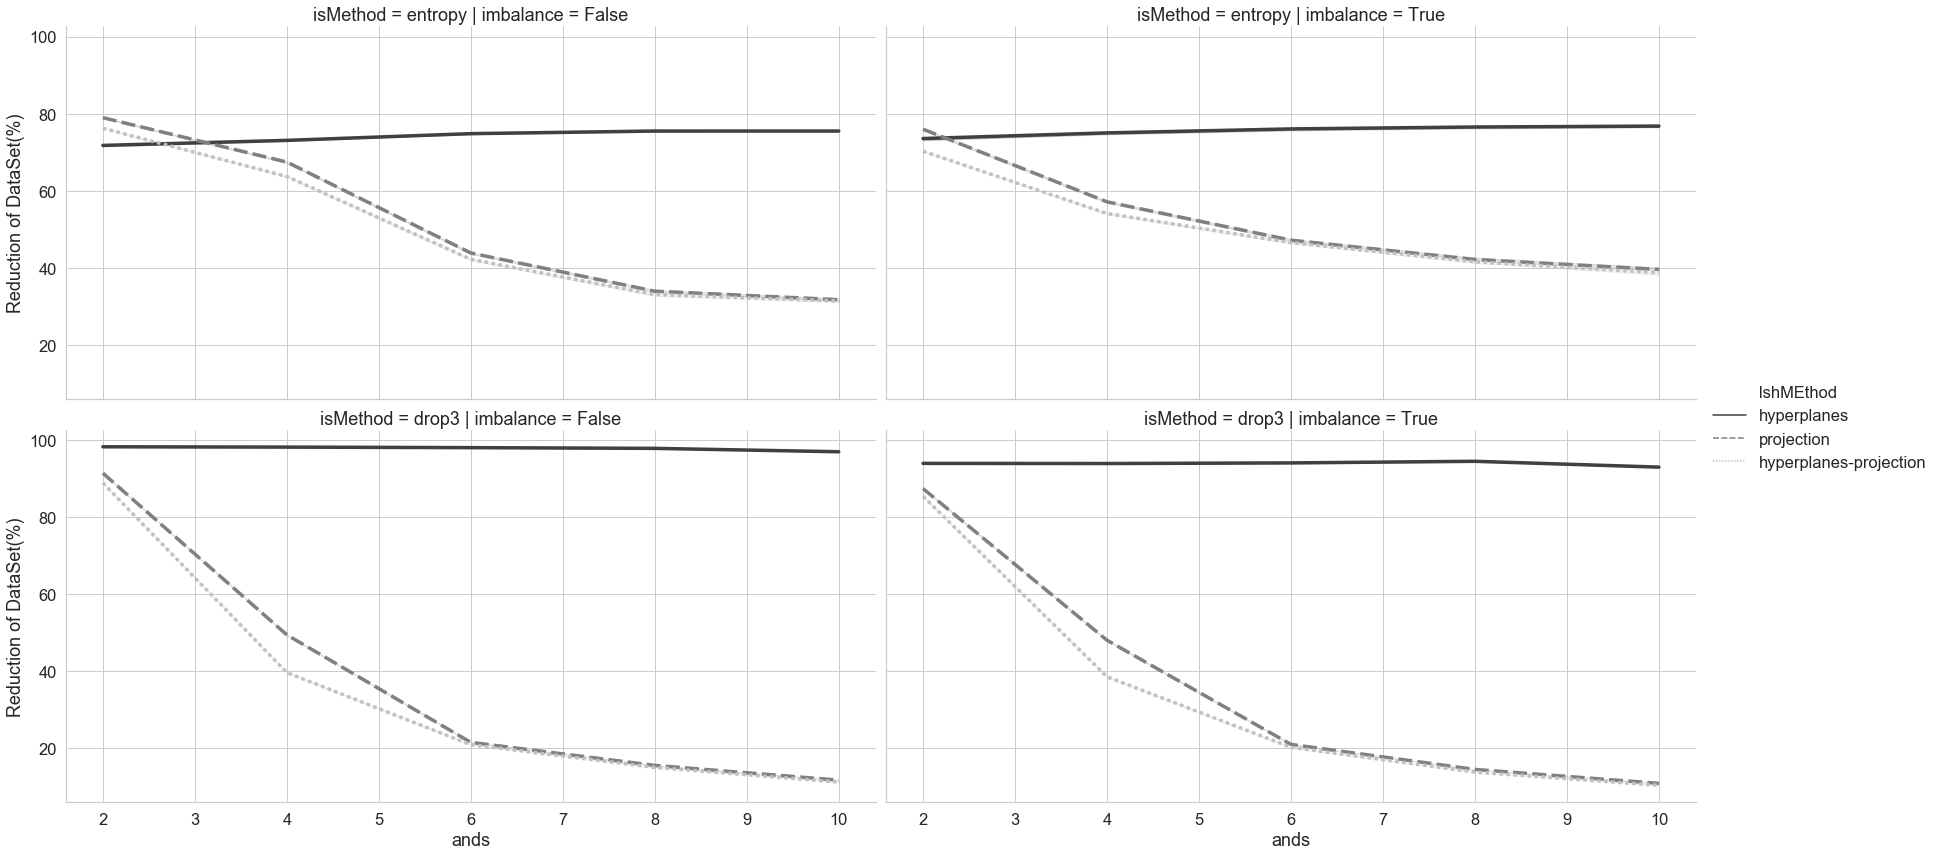

In [84]:
plotReduction(all_results[
    (~all_results.file.isin(['susyAllResults.csv']))], col = 'imbalance', row = 'isMethod')

In [150]:
def plotBuckets_reduction(df, col = 'isMethod', row = 'lshMEthod'):
    fil = (df['instanceSelection'] == 'IS') & (df['type'] == 'Train')
    df_pb_to_plot = df[fil].copy()    
    df_pb_to_plot['Reduction of DataSet(%)'] = (1 - df_pb_to_plot['reduction'])*100.0
    df_pb_to_plot['Bucket Intervals'] = pd.cut(df_pb_to_plot.buckets, bins = [0,10,100,1000,10000, np.inf])

    plot = sns.catplot(x="Bucket Intervals", y="Reduction of DataSet(%)", col=col, row = None,
               aspect=2, hue = 'lshMEthod',
                kind="point", data=df_pb_to_plot)

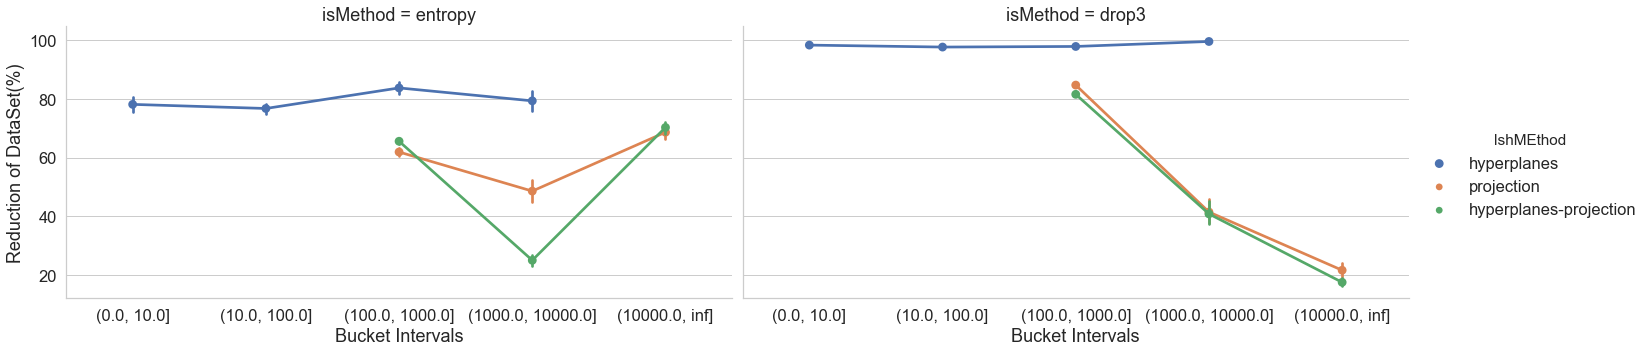

In [151]:
plotBuckets_reduction(all_results[all_results.imbalance==False])

### Comparacion entre metodos desde el punto de vista del performances

In [116]:
all_results['total'] = all_results.tp + all_results.tn + all_results.fn + all_results.fp
all_results[(all_results.file.isin(['p2pAllResults.csv']) ) & (all_results.instanceSelection == 'IS') & (all_results.type == 'Train') & (all_results.total>1779103)][]

,instanceSelection,lshMEthod,sizeBucket,ands,ors,imbalance,neigh,subBuckets,distance,isMethod,trees,depth,type,k,tp,tn,fp,fn,sensibility,specificity,precision,accuracy,F1,Gmean,wtdAcc,AreaROC,timeLSH,timeIS,buckets,buckMax,buckMin,buckAvg,reduction,file,total
17946,IS,projection,0.1,6,1,False,4,1000,6,entropy,10,10,Train,1,888.0,2507495.0,888.0,2015.0,30.589046,99.964599,50.0,99.884402,37.956828,55.297574,51.401712,0.987511,2.913263,1.803684,2504028.0,1893.0,1.0,1.606506,0.624058,p2pAllResults.csv,2511286.0
17948,IS,projection,0.1,6,1,False,4,1000,6,entropy,10,20,Train,1,2241.0,2308862.0,2241.0,627.0,78.138075,99.903033,50.0,99.876057,60.979592,88.352876,84.667563,0.999641,2.882470,1.700143,2304298.0,3003.0,1.0,1.745753,0.574666,p2pAllResults.csv,2313971.0
17950,IS,projection,0.1,6,1,False,4,1000,6,entropy,10,30,Train,1,2480.0,2401994.0,2480.0,303.0,89.112469,99.896859,50.0,99.884391,64.057859,94.350706,92.347786,0.998931,2.794926,1.707057,2394849.0,2248.0,1.0,1.679745,0.597798,p2pAllResults.csv,2407257.0
17952,IS,projection,0.1,6,1,False,4,1000,6,entropy,25,10,Train,1,840.0,2491004.0,840.0,2034.0,29.227557,99.966290,50.0,99.884797,36.890646,54.053404,50.449177,0.991395,3.010658,1.770754,2487664.0,3245.0,1.0,1.617073,0.619949,p2pAllResults.csv,2494718.0
17954,IS,projection,0.1,6,1,False,4,1000,6,entropy,25,20,Train,1,2213.0,2678075.0,2213.0,613.0,78.308563,99.917434,50.0,99.894675,61.031440,88.455586,84.791225,0.999209,2.847802,1.684873,2674955.0,3511.0,1.0,1.503851,0.666438,p2pAllResults.csv,2683114.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19120,IS,hyperplanes-projection,0.1,10,1,False,4,1000,6,entropy,25,20,Train,5,2260.0,3595244.0,2260.0,740.0,75.333333,99.937179,50.0,99.916678,60.106383,86.767510,82.714487,0.999014,7.347282,2.418262,3596506.0,1646.0,1.0,1.118330,0.894623,p2pAllResults.csv,3600504.0
19122,IS,hyperplanes-projection,0.1,10,1,False,4,1000,6,entropy,25,30,Train,5,2873.0,3534064.0,2873.0,109.0,96.344735,99.918772,50.0,99.915761,65.834097,98.115481,97.416946,0.998769,6.781217,3.601663,3535305.0,1961.0,1.0,1.137690,0.879408,p2pAllResults.csv,3539919.0
19124,IS,hyperplanes-projection,0.1,10,1,False,4,1000,6,entropy,50,10,Train,5,840.0,3576691.0,840.0,2198.0,27.649770,99.976520,50.0,99.915153,35.608309,52.576875,49.347795,0.994393,4.276837,3.825733,3578293.0,1332.0,1.0,1.124023,0.890021,p2pAllResults.csv,3580569.0
19126,IS,hyperplanes-projection,0.1,10,1,False,4,1000,6,entropy,50,20,Train,5,2294.0,3616221.0,2294.0,726.0,75.960265,99.936604,50.0,99.916610,60.304942,87.127555,83.153167,0.999247,6.756153,2.460565,3618414.0,1877.0,1.0,1.111559,0.899843,p2pAllResults.csv,3621535.0


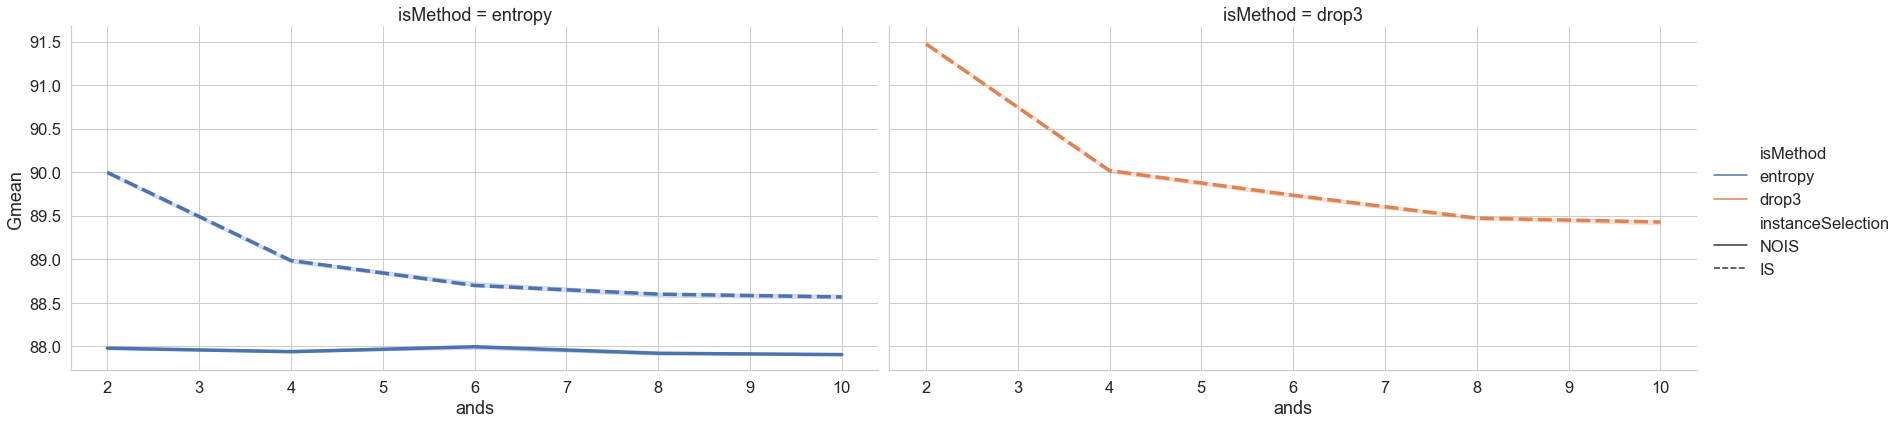

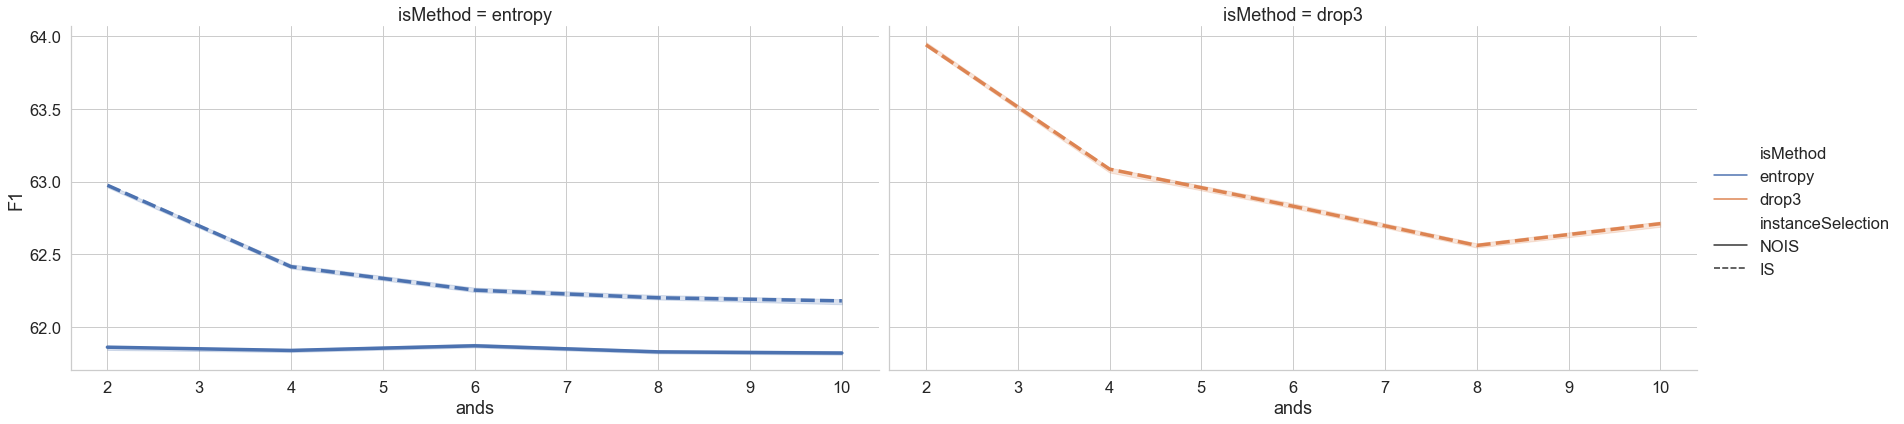

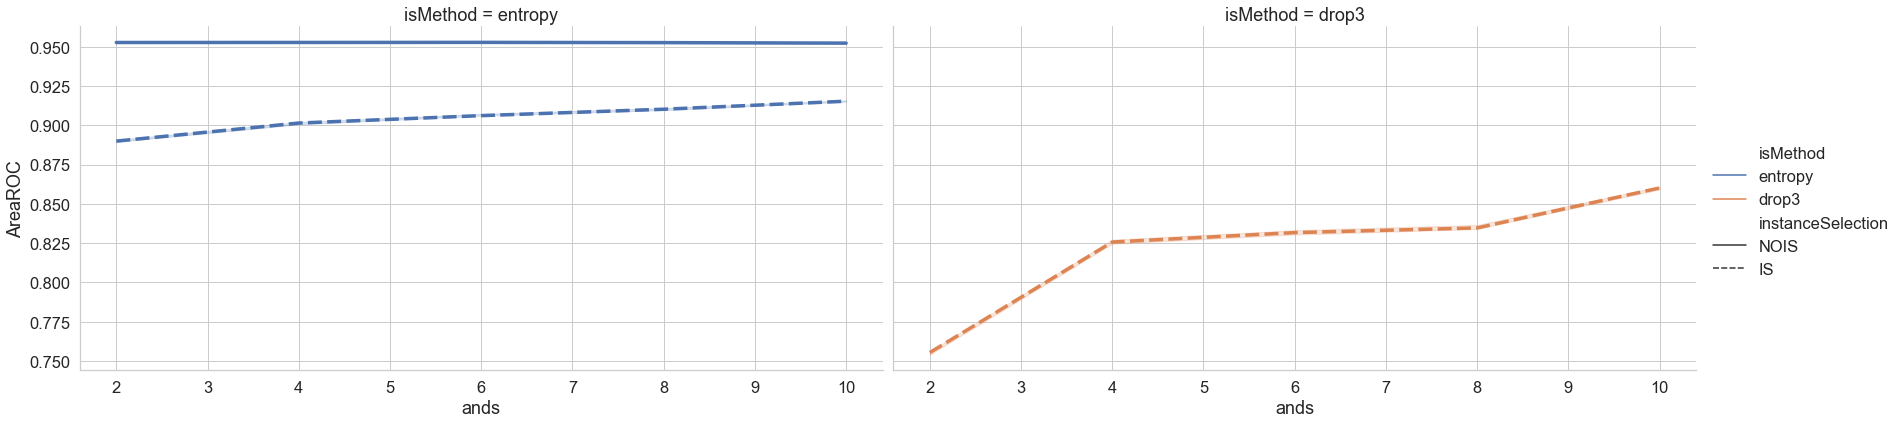

In [214]:
fil = (all_results ['type'] == 'Test') & (all_results.imbalance==True ) & (~all_results.file.isin(['susyAllResults.csv']))

plot = sns.relplot(x="ands", y="Gmean", height = 6, aspect=2, 
                    data=all_results[fil], 
                       kind="line",ci=10, style = 'instanceSelection', 
                       linewidth=3.5, hue = 'isMethod', col = 'isMethod')

plot = sns.relplot(x="ands", y="F1", height = 6, aspect=2, 
                    data=all_results[fil], 
                       kind="line",ci=10, style = 'instanceSelection', 
                       linewidth=3.5, hue = 'isMethod', col = 'isMethod')

plot = sns.relplot(x="ands", y="AreaROC", height = 6, aspect=2, 
                    data=all_results[fil], 
                       kind="line",ci=10, style = 'instanceSelection', 
                       linewidth=3.5, hue = 'isMethod', col = 'isMethod')



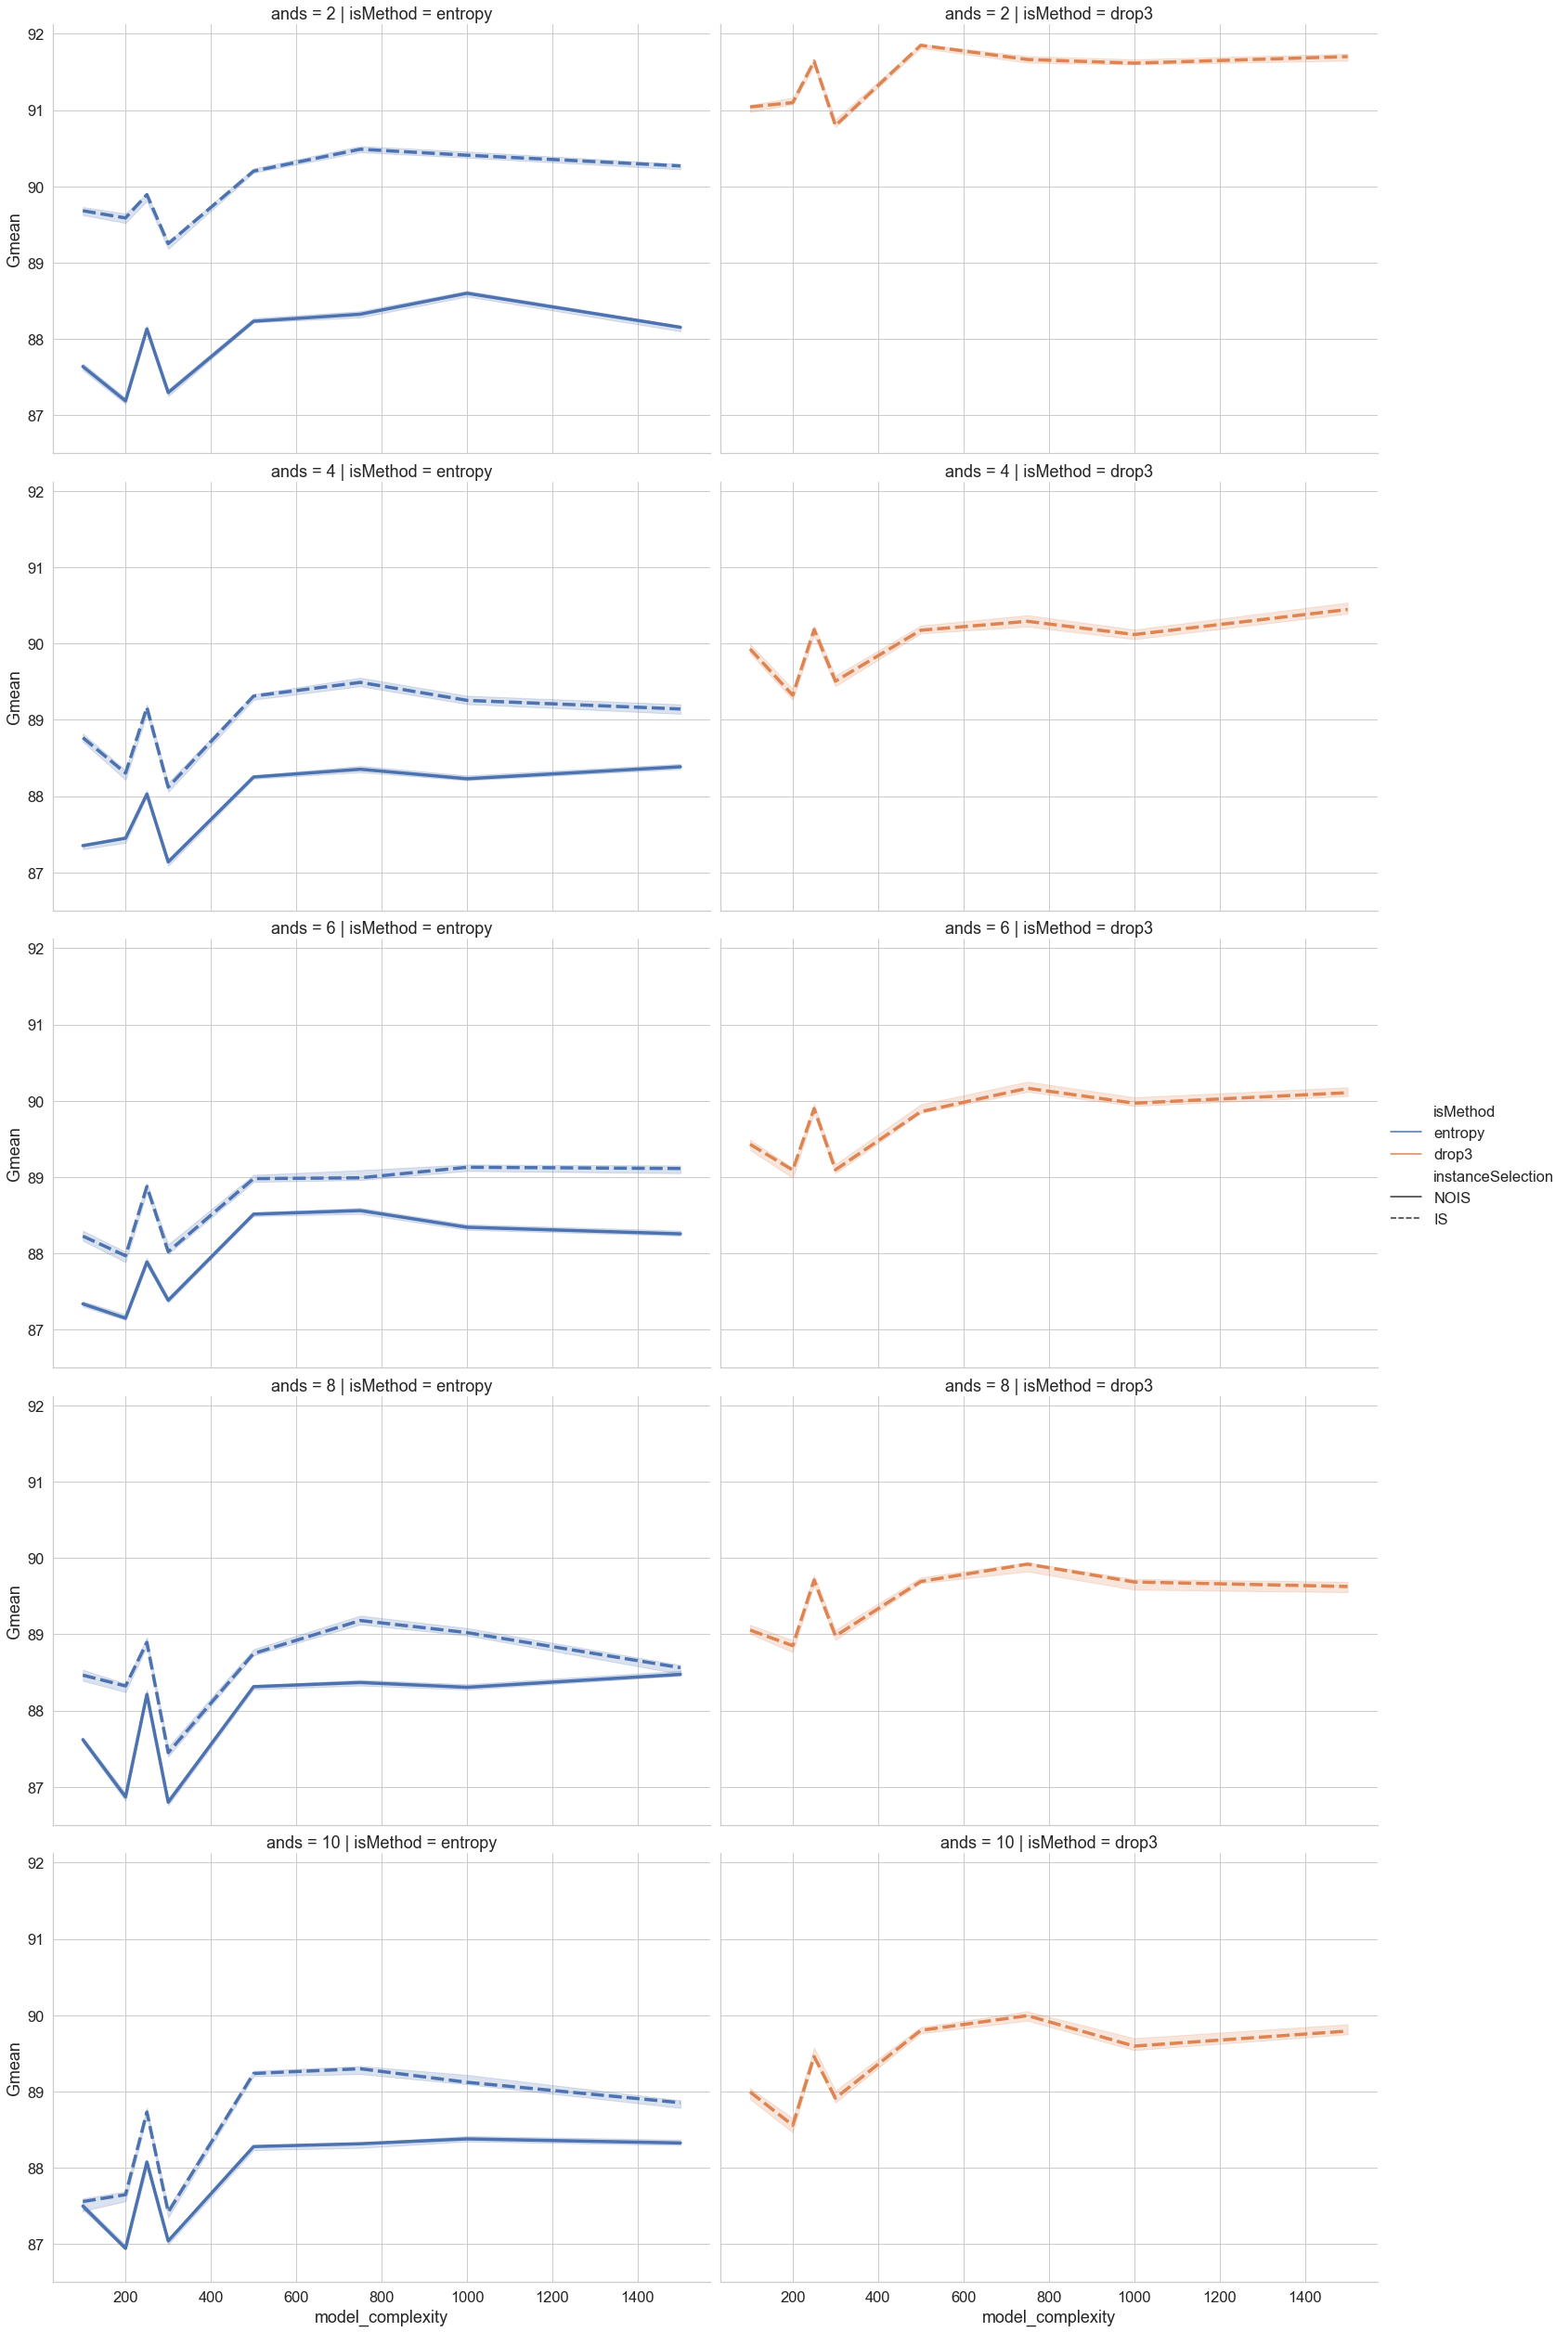

In [220]:
fil = (all_results ['type'] == 'Test') & (all_results.imbalance==True ) & (~all_results.file.isin(['susyAllResults.csv']))
plot = sns.relplot(x="model_complexity", y="Gmean", height = 7, aspect=1.5, 
                    data=all_results[fil], 
                       kind="line",ci=10, style = 'instanceSelection', 
                       linewidth=3.5, hue = 'isMethod', col = 'isMethod', row = 'ands')

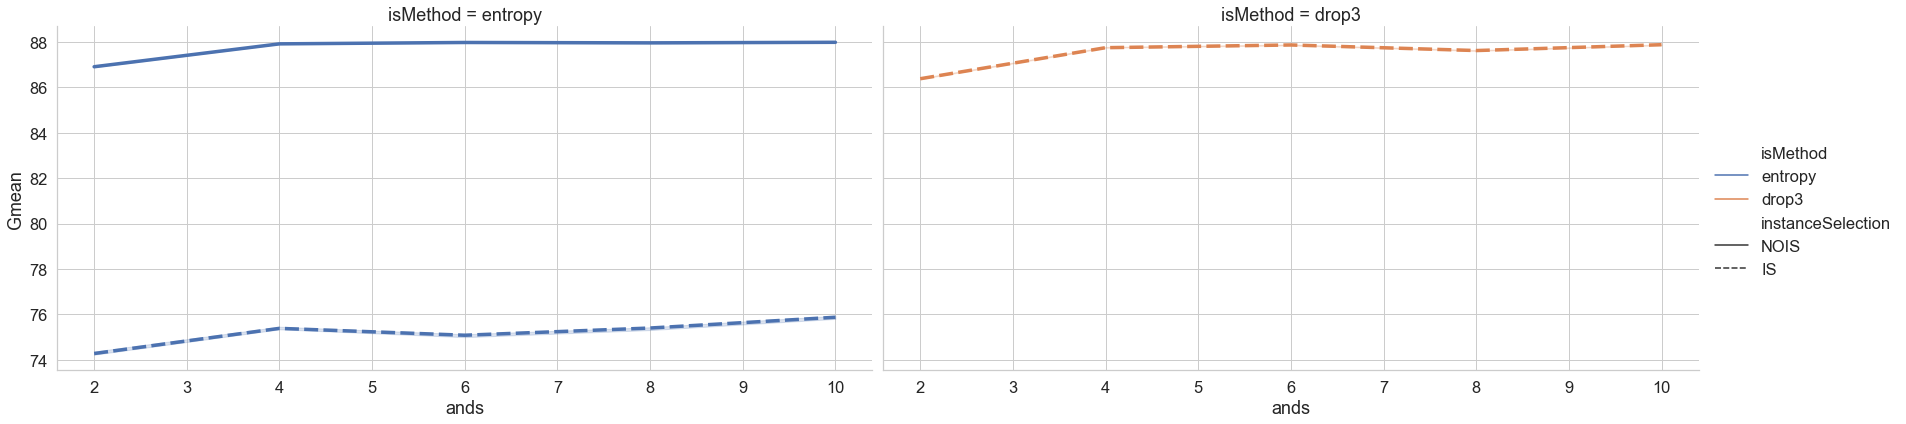

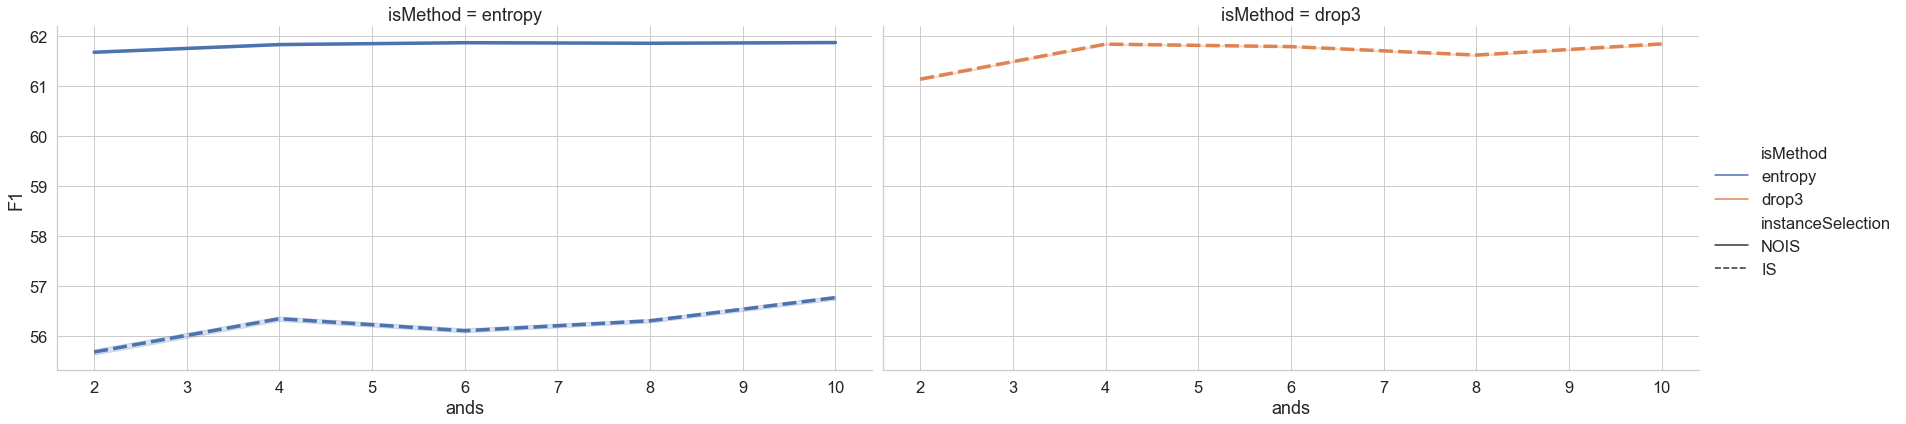

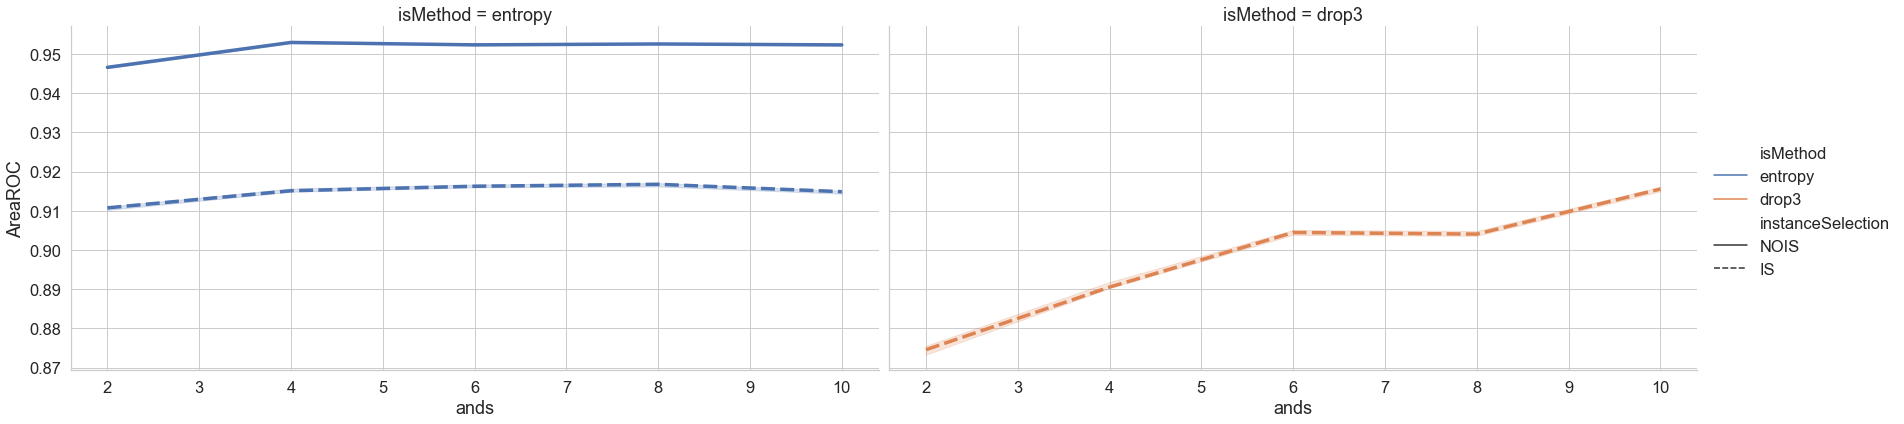

In [218]:
fil = (all_results ['type'] == 'Test') & (all_results.imbalance==False )

plot = sns.relplot(x="ands", y="Gmean", height = 6, aspect=2, 
                    data=all_results[fil], 
                       kind="line",ci=10, style = 'instanceSelection', 
                       linewidth=3.5, hue = 'isMethod', col = 'isMethod')

plot = sns.relplot(x="ands", y="F1", height = 6, aspect=2, 
                    data=all_results[fil], 
                       kind="line",ci=10, style = 'instanceSelection', 
                       linewidth=3.5, hue = 'isMethod', col = 'isMethod')

plot = sns.relplot(x="ands", y="AreaROC", height = 6, aspect=2, 
                    data=all_results[fil], 
                       kind="line",ci=10, style = 'instanceSelection', 
                       linewidth=3.5, hue = 'isMethod', col = 'isMethod')



In [ ]:
lshMEthods = ['hyperplanes', 'hyperplanes-projection', 'projection']
isOrNis = ['IS', 'NOIS']
isMEthod = ['entropy','drop3']
combinations = [(x,y,z) for x in lshMEthods for y in isOrNis for z in isMEthod]

def completeIS(dfToComplete):
    
    combinations = [(x,y,z) for x in lshMEthods for y in isOrNis for z in isMEthod]
    
    for lsh, isOrNis, isM in combinations:
        print(lsh, isOrNis, isM)
        
        